In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import time
import os
import tensorflow.contrib.slim as slim
from nets.vgg import vgg_16 as vgg
from nets.vgg import vgg_arg_scope
import preprocessing.imagenet_utils as imagenet_utils
import preprocessing.vgg as preprocessing
import PIL.Image as Image
import glob
from matplotlib import pyplot as plt
import math
from scipy import signal
import pandas as pd

from MASC_core import MASC_core

In [2]:
# Helper Functions 

def load_image(img_path):
    print("Loading image")
    img = np.array(Image.open(img_path))
    #img = imresize(img, (224, 224))
    # Converting shape from [224,224,3] tp [1,224,224,3]
    #x = np.expand_dims(img, axis=0)
    # Converting RGB to BGR for VGG
    #x = x[:,:,:,::-1]
    return img

    
def image_crop(im, bbox):
    return im[bbox[0]:bbox[0]+bbox[2], bbox[1]:bbox[1]+bbox[3],:]


def gauss2D(shape,sigma):
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h


# importing the model

model_path = './modelparams/vgg_16.ckpt'
labels_to_names, label_names = imagenet_utils.create_readable_names_for_imagenet_labels()

In [3]:
# Set Parameters 

# RF Organization
    
crop_sizes= np.array([[200, 200], [200, 200], [250, 250], [250, 250], [300, 300], [350, 350], [400, 400], [450, 450], [500, 500]])

row_steps = [100+100*x for x in range(5)] 
col_steps = [100+100*x for x in range(8)] 
row_shifts = np.concatenate((np.negative(row_steps[::-1]) , [0] , (row_steps)), axis=0) 
col_shifts = np.concatenate((np.negative(col_steps[::-1]) , [0] , (col_steps)), axis=0) 

# for filename in glob.glob('final_images/*.jpg'):
#test_images_path = [glob.glob(test_images_dir + "*.jpg")][0]

image_path = 'present_094.png'   
cat_name = 'clock'

cates = ['clock' ,'crib','fan','garbage_can','microwave_oven','rug','socks','teddy_bear','tent']

imagenet_cat_dict = {
    'clock' : 409,
    'crib'  : 520,
    'fan'   : 545,
    'garbage_can'    : 412,
    'microwave_oven' : 651,
    'rug'   : 741,
    'socks' : 806,
    'teddy_bear'     : 850,
    'tent'  : 672 
}

max_num_fixs = 20
use_image_foreground_for_object_arrays = 1

use_GradCAM = 1
use_CCF = 1
if (use_CCF):
    CCF_w = np.zeros( (len(cates),512))
    for c in range(len(cates)):
        image_dir = "./object_array_displays_fixation_data/CCFs_object_array_categories/"
        w = np.load(image_dir + cates[c] + '_conv5_3_mean_map_w.npy')
        CCF_w[c,:] = w / np.max(w)

apply_IOR = 1
IOR_size = 200  # pixels
IOR_offset = math.floor(IOR_size/2)
IOR_sigma = IOR_size/2 ;
filt_IOR = gauss2D([IOR_size,IOR_size], IOR_sigma) 
filt_IOR = filt_IOR/np.max(filt_IOR)

Loading image


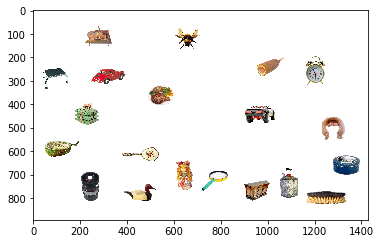

(893, 1428, 3)
Eye_movement  1
INFO:tensorflow:Restoring parameters from ./modelparams/vgg_16.ckpt
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


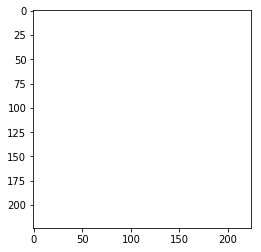

['Fixated area of the image and the classificatoin results']
0	 category: cleaver, meat cleaver, chopper; confidence:3.5071,	labelID: n03041632 499
1	 category: envelope; confidence:3.3408,	labelID: n03291819 549
2	 category: can opener, tin opener; confidence:3.0919,	labelID: n02951585 473
3	 category: corkscrew, bottle screw; confidence:3.0105,	labelID: n03109150 512
4	 category: face powder; confidence:2.9736,	labelID: n03314780 551
Priority map


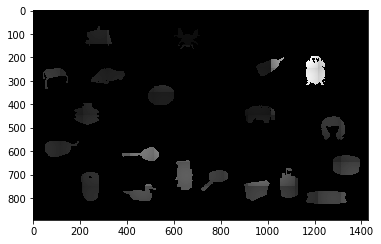

0.9885251073398196


/home/ec2-user/SageMaker/BCN/MASC_core.py:16: RuntimeWarning: invalid value encountered in true_divide
  phi=np.arctan( np.divide(np.multiply(np.exp(u/RETINA_BU), np.sin(v/RETINA_BV) ), np.multiply(np.exp(u/RETINA_BU) , np.cos(v/RETINA_BV))-1.0))


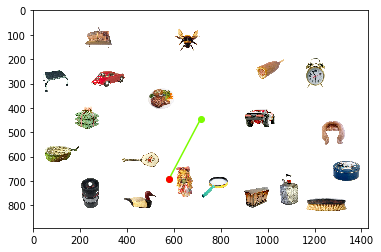

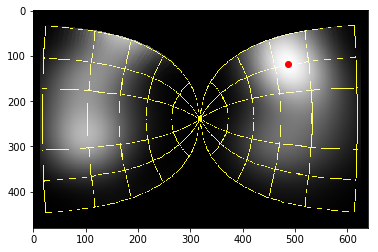

Eye_movement  2
INFO:tensorflow:Restoring parameters from ./modelparams/vgg_16.ckpt


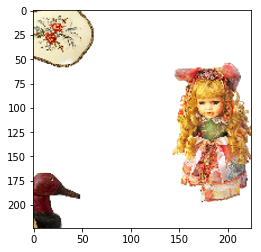

['Fixated area of the image and the classificatoin results']
0	 category: necklace; confidence:6.6009,	labelID: n03814906 679
1	 category: cock; confidence:5.8710,	labelID: n01514668 7
2	 category: strawberry; confidence:5.6472,	labelID: n07745940 949
3	 category: pomegranate; confidence:5.6470,	labelID: n07768694 957
4	 category: hair slide; confidence:5.1182,	labelID: n03476684 584
Priority map


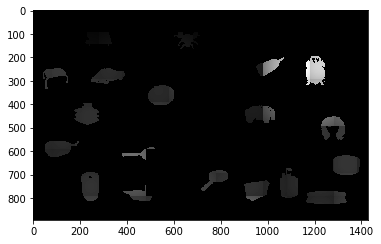

0.937305252667649


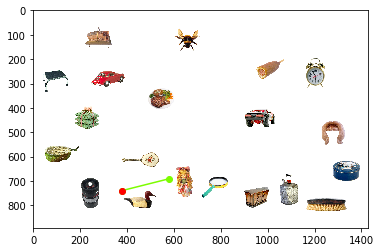

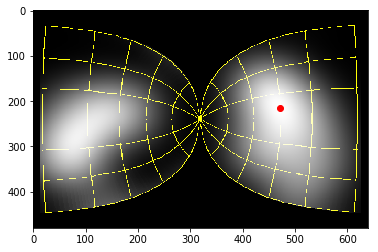

Eye_movement  3
INFO:tensorflow:Restoring parameters from ./modelparams/vgg_16.ckpt


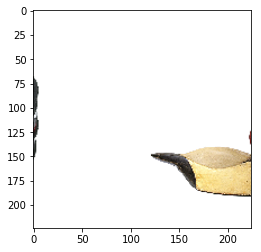

['Fixated area of the image and the classificatoin results']
0	 category: sandal; confidence:6.2885,	labelID: n04133789 774
1	 category: rhinoceros beetle; confidence:5.8375,	labelID: n02174001 306
2	 category: buckeye, horse chestnut, conker; confidence:5.7889,	labelID: n12768682 990
3	 category: clog, geta, patten, sabot; confidence:5.7298,	labelID: n03047690 502
4	 category: chocolate sauce, chocolate syrup; confidence:4.4457,	labelID: n07836838 960
Priority map


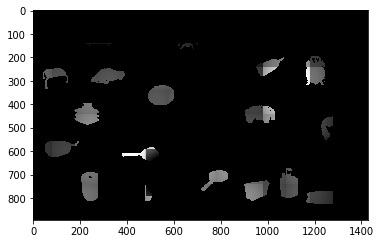

0.9056979615177293


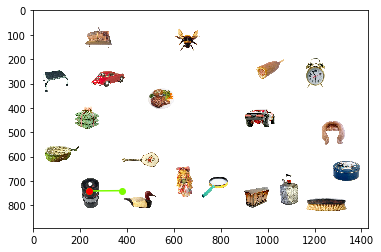

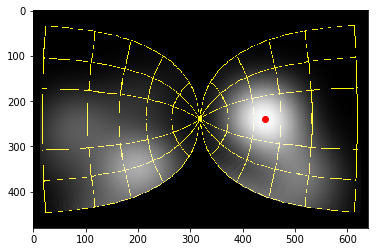

Eye_movement  4
INFO:tensorflow:Restoring parameters from ./modelparams/vgg_16.ckpt


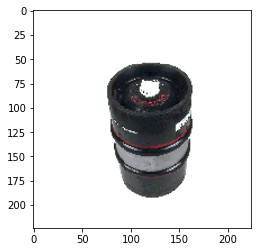

['Fixated area of the image and the classificatoin results']
0	 category: loupe, jeweler's loupe; confidence:10.5994,	labelID: n03692522 633
1	 category: beer bottle; confidence:9.5970,	labelID: n02823428 440
2	 category: puck, hockey puck; confidence:9.5715,	labelID: n04019541 746
3	 category: wine bottle; confidence:9.0940,	labelID: n04591713 907
4	 category: magnetic compass; confidence:8.9096,	labelID: n03706229 635
Priority map


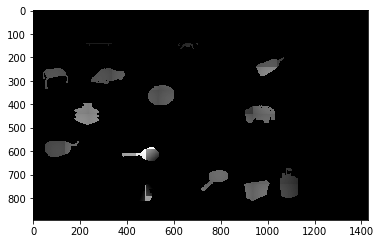

1.0


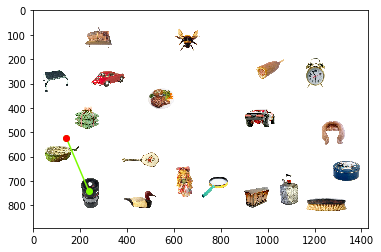

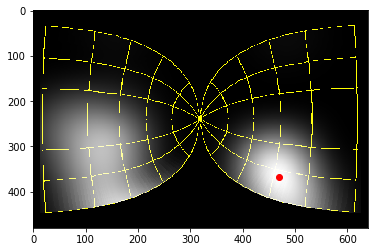

Eye_movement  5
INFO:tensorflow:Restoring parameters from ./modelparams/vgg_16.ckpt


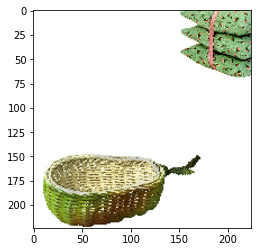

['Fixated area of the image and the classificatoin results']
0	 category: ear, spike, capitulum; confidence:8.3915,	labelID: n13133613 998
1	 category: strainer; confidence:8.1902,	labelID: n04332243 828
2	 category: shopping basket; confidence:8.1058,	labelID: n04204238 790
3	 category: corn; confidence:7.8356,	labelID: n12144580 987
4	 category: acorn; confidence:7.7329,	labelID: n12267677 988
Priority map


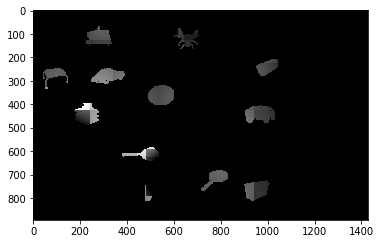

0.9737798018504087


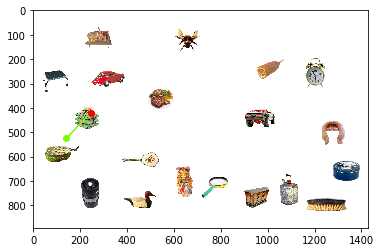

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


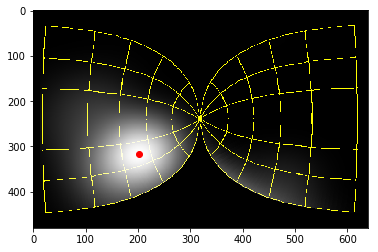

Eye_movement  6
INFO:tensorflow:Restoring parameters from ./modelparams/vgg_16.ckpt


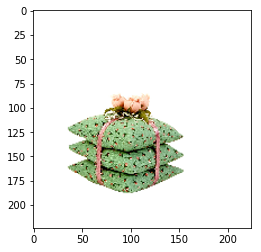

['Fixated area of the image and the classificatoin results']
0	 category: custard apple; confidence:10.8967,	labelID: n07760859 956
1	 category: hair slide; confidence:7.6378,	labelID: n03476684 584
2	 category: artichoke, globe artichoke; confidence:7.2334,	labelID: n07718747 944
3	 category: honeycomb; confidence:7.1098,	labelID: n03530642 599
4	 category: purse; confidence:6.6477,	labelID: n04026417 748
Priority map


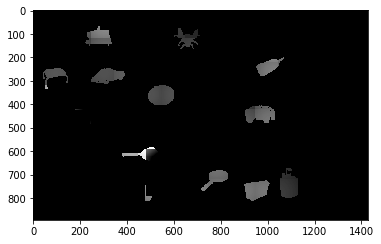

0.6826376405880794


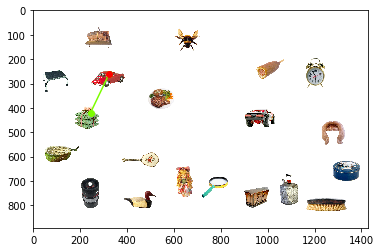

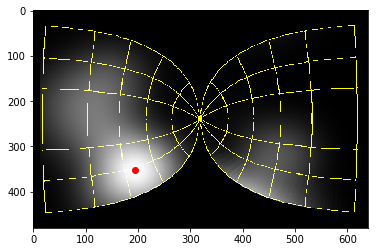

Eye_movement  7
INFO:tensorflow:Restoring parameters from ./modelparams/vgg_16.ckpt


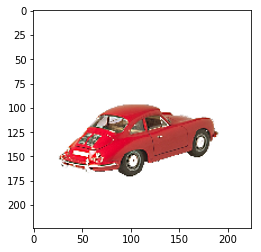

['Fixated area of the image and the classificatoin results']
0	 category: racer, race car, racing car; confidence:9.9400,	labelID: n04037443 751
1	 category: convertible; confidence:9.1422,	labelID: n03100240 511
2	 category: car wheel; confidence:9.0549,	labelID: n02974003 479
3	 category: tow truck, tow car, wrecker; confidence:9.0225,	labelID: n04461696 864
4	 category: pickup, pickup truck; confidence:8.9362,	labelID: n03930630 717
Priority map


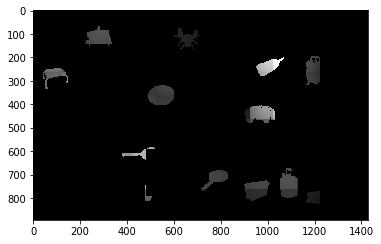

0.5982141425101524


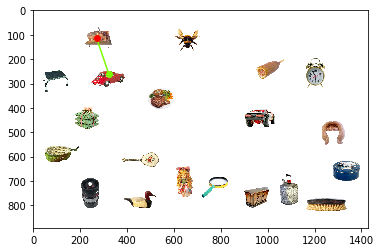

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


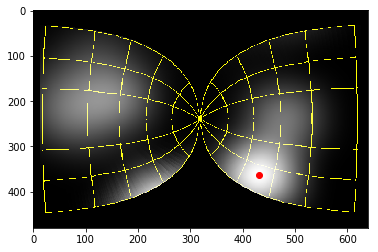

Eye_movement  8
INFO:tensorflow:Restoring parameters from ./modelparams/vgg_16.ckpt


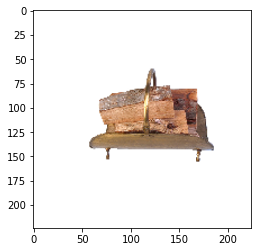

['Fixated area of the image and the classificatoin results']
0	 category: lumbermill, sawmill; confidence:5.9964,	labelID: n03697007 634
1	 category: mousetrap; confidence:5.7527,	labelID: n03794056 674
2	 category: hook, claw; confidence:5.4891,	labelID: n03532672 600
3	 category: chime, bell, gong; confidence:5.2914,	labelID: n03017168 494
4	 category: airship, dirigible; confidence:5.0872,	labelID: n02692877 405
Priority map


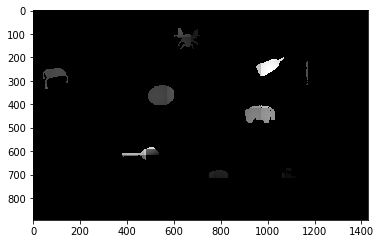

0.9695437229472885


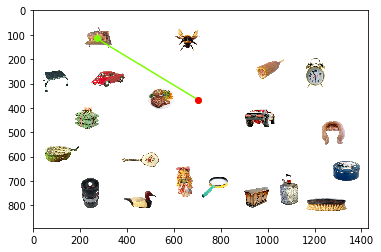

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


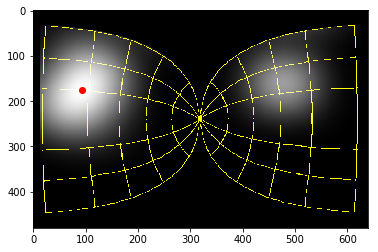

Eye_movement  9
INFO:tensorflow:Restoring parameters from ./modelparams/vgg_16.ckpt


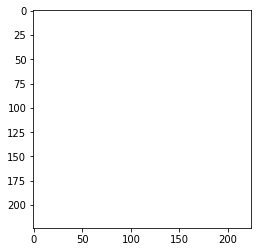

['Fixated area of the image and the classificatoin results']
0	 category: cleaver, meat cleaver, chopper; confidence:3.4997,	labelID: n03041632 499
1	 category: envelope; confidence:3.3603,	labelID: n03291819 549
2	 category: can opener, tin opener; confidence:3.1079,	labelID: n02951585 473
3	 category: corkscrew, bottle screw; confidence:2.9992,	labelID: n03109150 512
4	 category: face powder; confidence:2.9753,	labelID: n03314780 551
Priority map


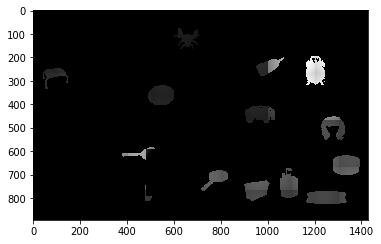

0.8740997926479389


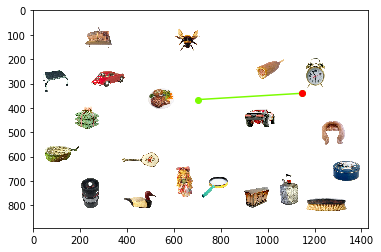

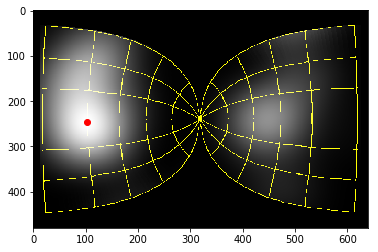

Eye_movement  10
INFO:tensorflow:Restoring parameters from ./modelparams/vgg_16.ckpt


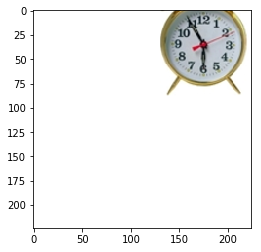

['Fixated area of the image and the classificatoin results']
0	 category: analog clock; confidence:13.6917,	labelID: n02708093 409
1	 category: wall clock; confidence:13.0140,	labelID: n04548280 892
2	 category: stopwatch, stop watch; confidence:12.8295,	labelID: n04328186 826
3	 category: barometer; confidence:12.3227,	labelID: n02794156 426
4	 category: magnetic compass; confidence:11.6217,	labelID: n03706229 635


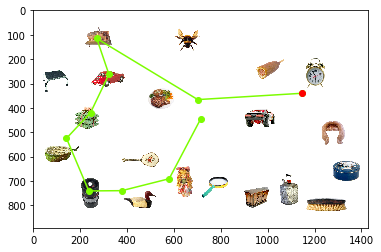

In [8]:

# all_fixations = np.zeros((len(search_displays_data),max_num_fixs,2))
# target_presence = np.zeros((len(search_displays_data)))

for im_num in range(1):#len(search_displays_data)):
    
    
#     cat_name = search_displays_data["categorical_cue"][im_num]
#     cat_name = '_'.join(cat_name.split())
    
    search_target = imagenet_cat_dict[cat_name] 
        
#     print(cat_name + '    ' + str(search_target) )
#     image_name = search_displays_data["disp_im_name"][im_num]
    
#     image_path = test_images_dir + '/' + image_name
#     print(image_path)

    search_im = load_image(image_path)
    
#     with open('./Image_names_object_array_dislays.txt', 'a') as f1:
#         f1.write(image_name + os.linesep)
    
    plt.imshow(search_im)
    plt.show()
    print(search_im.shape)
    im_size = search_im.shape
    im_h = im_size[0]
    im_w = im_size[1]

    fixation_map = np.zeros((im_h+IOR_size,im_w+IOR_size));

    im_col_fix = math.floor(im_w/2) # 493 #
    im_row_fix = math.floor(im_h/2)  # 673 #
    
    im_corner_row = 1500-math.floor(im_h/2)
    im_corner_col = 2000-math.floor(im_w/2) 

    fixations_row = np.zeros((max_num_fixs))
    fixations_col = np.zeros((max_num_fixs))
    
    fixations_row[0] = im_row_fix
    fixations_col[0] = im_col_fix

    for fix in range(1,max_num_fixs):
        
        print("Eye_movement  " + str(fix))

        row_fix = im_corner_row + im_row_fix 
        col_fix = im_corner_col + im_col_fix

        im_foreground = 255-np.mean(search_im.astype(float), axis=2)
        im_foreground_norm = im_foreground #np.multiply(im_foreground,np.divide(im_foreground, im_foreground))
        nonzero = im_foreground > 0
        im_foreground_norm[nonzero] /= im_foreground[nonzero]
    #     plt.imshow(im_foreground_norm)
    #     plt.show()

        backg = 255*np.ones((3000,4000,3))
        backg[im_corner_row:im_corner_row + im_h,im_corner_col:im_corner_col+im_w,:]=search_im;
        backg = np.uint8(backg)
#         plt.imshow(backg)
#         plt.show()

        backg_RF = backg;
        sample_size = len(col_shifts)* len(row_shifts) 
        conv5_3_feat = np.zeros((sample_size,14,14,512),dtype=float)
        #conv5_3_grads = np.zeros((sample_size,14,14,512),dtype=float)
        conv5_3_p = np.zeros((sample_size,14,14),dtype=float)

        conv5_3_p_ub = np.zeros((sample_size,14,14),dtype=float)

        crop_box_center_all = np.zeros((sample_size,2),dtype=float)
        crop_box_corner_all = np.zeros((sample_size,2),dtype=float)

        g_2 = tf.Graph()          
        with g_2.as_default():
            vgg_inputs = tf.placeholder(dtype=tf.float32, shape=[None, 224, 224, 3], name='input_image')
            with slim.arg_scope(vgg_arg_scope()):
                vgg_output, vgg_endpoints = vgg(vgg_inputs, is_training=False)

            # todo: Compute gradient layer by layer
            init_fn = slim.assign_from_checkpoint_fn(model_path, slim.get_model_variables('vgg_16'))

            sess_2 = tf.Session(graph=g_2)
            sess_2.run(tf.global_variables_initializer())
            init_fn(sess_2)
            crop_index_overall = 0
            for row_RF in range(len(row_shifts)):  # 

                sample_size = len(col_shifts)
                crop_set = np.zeros((sample_size,224,224,3),dtype=float)
                crop_index = 0

                for col_RF in range(len(col_shifts)):  #
                    row_dis = abs(math.floor((len(row_shifts)/2)) - row_RF) 
                    col_dis = abs(math.floor((len(col_shifts)/2)) - col_RF) 
                    crop_ind = max(row_dis,col_dis)

                    crop_size = crop_sizes[crop_ind]
                    #print(crop_size)
                    crop_box_center = np.array([row_fix + row_shifts[row_RF] , col_fix + col_shifts[col_RF]]) 
                    crop_box_center_all[crop_index_overall] = crop_box_center
                    #print(crop_box_center)
                    crop_corner = crop_box_center - math.floor(crop_size[0]/2) 
                    crop_box_corner_all[crop_index_overall] = crop_corner
                    #print(crop_corner)
                    im_crop = image_crop(backg_RF,np.concatenate((crop_corner, crop_size), axis = 0)) 

                    s_image = Image.fromarray(im_crop)
                    s_image = s_image.resize([224, 224], resample=Image.BICUBIC)
                    im_crop_re = np.asarray(s_image, dtype=np.float32)

                    if row_RF == math.floor(len(row_shifts)/2) and col_RF == math.floor(len(col_shifts)/2):  
                        plt.imshow(s_image)
                        plt.show()
                        time.sleep(0.5)

            #         if len(s_image.shape) < 3:
            #             print("Image is not RGB 3Dimensional data")
                    im_crop_re = preprocessing.mean_image_subtraction(im_crop_re)
                    im_crop_re = np.expand_dims(im_crop_re, axis=0)

                    crop_set[crop_index,:,:,:] = im_crop_re
                    crop_index = crop_index + 1 
                    crop_index_overall = crop_index_overall + 1
                  # crop_ind = crop_array(col_RF);

                #print('Running the session')
                vgg_all_output = sess_2.run([vgg_output, vgg_endpoints], feed_dict={vgg_inputs: crop_set})
                [current_vgg_output, current_vgg_endpoints] = vgg_all_output
                
                conv5_3_f = current_vgg_endpoints['vgg_16/conv5/conv5_3']                

                if row_RF == math.floor(len(row_shifts)/2):
                    
                    print(["Fixated area of the image and the classificatoin results"])

                    s_output = current_vgg_output[math.floor(len(col_shifts)/2)]
                    sorted_cates = np.argsort(-s_output)
                    selected_cates = sorted_cates[0:5]

                    for i, catId in enumerate(selected_cates):
                        # !!!: Notice here this is a catId+1 instead of catID
                        print('{:d}\t category: {:s}; confidence:{:.4f},\tlabelID: {:s} {:d}'.format(i, labels_to_names[
                            catId + 1], s_output[catId], label_names[catId], catId))

                if use_GradCAM:
                # apply grad-cam

                    layer_name =  'vgg_16/conv5/conv5_3'
                    conv_layer = vgg_endpoints[layer_name]  #'vgg_16/conv5/conv5_3'

                    one_hot = tf.sparse_to_dense(search_target, [1000], 1.0)
                    signal_one_hot = tf.multiply(vgg_endpoints['vgg_16/fc8'], one_hot)
                    loss = tf.reduce_mean(signal_one_hot)

                    grads = tf.gradients(loss, conv_layer)[0]
                #     # Normalizing the gradients
                    norm_grads = tf.div(grads, tf.sqrt(tf.reduce_mean(tf.square(grads))) + tf.constant(1e-5))

                    outputs, grads_val, loss_val = sess_2.run([conv_layer, norm_grads, loss], feed_dict={vgg_inputs: crop_set})
            #         output = output[0]           # [7,7,512]
            #         grads_val = grads_val[0]	 # [7,7,512]
                    outputs = np.asarray(outputs)
                    grads_val = np.asarray(grads_val)
                    #outputs_re = np.reshape(outputs,(outputs.shape[0]*outputs.shape[1]*outputs.shape[2], outputs.shape[3]))

                    all_weights = np.mean(grads_val, axis = (1, 2)) 			# [?,512]
                    all_weights = all_weights/np.max(all_weights)
                    p = np.ones(outputs.shape[0 : 3], dtype = np.float32)	# [?,14,14]
                    p_ub = np.ones(outputs.shape[0 : 3], dtype=np.float32)  # [?,14,14]    
                    #np.matmul(output_re, np.transpose(weights))

                    for j in range(outputs.shape[0]):
                        weights = all_weights[j,:]
                        output = outputs[j,:]
            #           # Taking a weighted average
                        for i, w in enumerate(weights):
                            p[j,:] += w * output[:, :, i]
                        
                        
                elif(use_CCF == 1):
                                                     
                    weights = CCF_w[cates.index(cat_name),:]
                    
                    p = np.matmul(conv5_3_f,weights)
                        
                
                p_ub = np.mean(conv5_3_f, axis=3 )

                ind_beg=17*(row_RF)
                conv5_3_feat[ind_beg:ind_beg+17,:,:,:] = current_vgg_endpoints['vgg_16/conv5/conv5_3']
                #conv5_3_grads[ind_beg:ind_beg+17,:,:,:] = grads_val
                conv5_3_p[ind_beg:ind_beg+17,:,:] = p

                conv5_3_p_ub[ind_beg:ind_beg+17,:,:] = p_ub


        if(s_output[search_target] > 5  and search_target in selected_cates[:5]):
            #target_presence[im_num] = 1
            break
        
        priority_big = np.zeros((3000,4000))

        crop_box_center_all = crop_box_center_all.astype(int)
        priority_big[crop_box_center_all[:,0], crop_box_center_all[:,1]] = np.max(conv5_3_p, axis = (1, 2))

        filt = gauss2D( (200,200), 100)
        priority_big_map = signal.fftconvolve(priority_big, filt, mode='same')

        priority_map = priority_big_map[im_corner_row:im_corner_row+im_h, im_corner_col:im_corner_col + im_w]
        priority_map = priority_map/np.max(priority_map)
        #priority_map = priority_map 
        if (use_image_foreground_for_object_arrays == 1):
            priority_map = np.multiply(im_foreground_norm, priority_map)

        if (apply_IOR): 
            #fixation_map[row_im_f+IOR_offset,col_im_f+IOR_offset] = 1 
            fixation_map[im_row_fix:im_row_fix+2*IOR_offset,im_col_fix:im_col_fix+2*IOR_offset] = \
                fixation_map[im_row_fix:im_row_fix+2*IOR_offset,im_col_fix:im_col_fix+2*IOR_offset] + filt_IOR
            IOR_map = fixation_map[IOR_offset:IOR_offset+im_h,IOR_offset:IOR_offset+im_w] 
            #IOR_map = IOR_map / np.max(IOR_map)
            priority_map_fixs = priority_map - IOR_map 
            priority_map_fixs= priority_map_fixs.clip(min=0)
            
        print("Priority map")
        plt.imshow(priority_map_fixs, cmap='gray')  # _fixs/np.max(priority_map_fixs)
        plt.show()
        time.sleep(0.5)
        print(np.max(priority_map_fixs))
        if(np.max(priority_map_fixs) < 0.4):
            break
            
        # MASC_core is the main function 
        # input arguments: 
        #     priority_map: Priority map
        #     RETINA_PIXDEG: The number of pixels in one degree visual angle of the visual display  
        #     im_col_fix: The column for the current fixation (x)
        #     im_row_fix: The row for the current fixtion (y)
        # outputs: 
        #     col_im_m: The column for the next fixation (x)
        #     row_im_m: The row for the next fixation (x)
        #     moto_Coll_framed: The activity map in the motor layer of the SC 
        #     col_m_coll: the column coordiatne of the winning population in the SC motor map
        #     row_m_coll: the row coordiatne of the winning population in the SC motor map

        RETINA_PIXDEG = 22
        col_im_m, row_im_m, moto_Coll_framed, col_m_coll, row_m_coll = MASC_core(priority_map_fixs, RETINA_PIXDEG, im_col_fix, im_row_fix)



        plt.imshow(search_im, aspect='auto')
        plt.plot([im_col_fix, col_im_m], [im_row_fix, row_im_m], '-o', color='lawngreen')
        plt.plot(col_im_m, row_im_m, 'o',color='red')
        plt.show()

        plt.imshow(moto_Coll_framed, aspect='auto')
        plt.plot(col_m_coll, row_m_coll, 'o',color='red')
        plt.show()

        im_col_fix = col_im_m
        im_row_fix = row_im_m

        fixations_row[fix] = im_row_fix
        fixations_col[fix] = im_col_fix

    plt.imshow(search_im, aspect='auto')
    plt.plot(fixations_col[0:fix], fixations_row[0:fix], '-o', color='lawngreen')
    plt.plot(fixations_col[fix-1], fixations_row[fix-1], 'o',color='red')
#     plt.savefig('./object_array_displays_fixation_data/model_scanpaths_present/' + image_name.split('.')[0] + \
#                 '_scanpath_'+ str(target_presence[im_num]) + '.jpg')

    plt.show()
    
    
#     all_fixations[im_num,:,0] = fixations_col
#     all_fixations[im_num,:,1] = fixations_row
    
#     np.save('Deep-BCN_CCF_object_array_target_present.npy',all_fixations)